# Описание проекта

**Основная задача проекта - разобраться в причинах убытков компании-разработчика приложения Procrastinate Pro+ в последние несколько месяцев и помочь компании выйти в плюс.**

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

**- Лог сервера с данными об их посещениях**

Структура `visits_info_short.csv`:
1) `User Id` — уникальный идентификатор пользователя

2) `Region` — страна пользователя

3) `Device` — тип устройства пользователя

4) `Channel` — идентификатор источника перехода

5) `Session Start` — дата и время начала сессии

6) `Session End` — дата и время окончания сессии

**- Выгрузка их покупок за этот период**

Структура `orders_info_short.csv`:
1) `User Id` — уникальный идентификатор пользователя

2) `Event Dt` — дата и время покупки

3) `Revenue` — сумма заказа

**- Рекламные расходы**

Структура `costs_info_short.csv`:
1) `dt` — дата проведения рекламной кампании

2) `Channel` — идентификатор рекламного источника

3) `costs` — расходы на эту кампанию

**В данной работе предстоит изучить:**
- откуда приходят пользователи и какими устройствами они пользуются
- сколько стоит привлечение пользователей из различных рекламных каналов
- сколько денег приносит каждый клиент
- когда расходы на привлечение клиента окупаются
- какие факторы мешают привлечению клиентов

Перед началом работы загрузим необходимые для обработки библиотеки:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

## Загрузка данных и подготовка их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Считаем данные из csv-файлов в датафреймы, сохраним в переменные visits, orders, costs и изучим первые 10 строк каждой таблицы:

In [ ]:
visits, orders, costs = ( #читаем csv-файлы и сохраняем в переменные с данными
    pd.read_csv('/datasets/visits_info_short.csv'),  #журнала визитов
    pd.read_csv('/datasets/orders_info_short.csv'),  #заказов
    pd.read_csv('/datasets/costs_info_short.csv'))   #расходов

In [ ]:
display(visits.head(10))
display(orders.head(10))
costs.head(10)
#выведем первые 10 значений

Видим, что название колонок датасета заведены не соответсвующе змеиному регистру, исправим это:

In [ ]:
visits.rename(columns = {'User Id': 'user_id','Session Start' : 'session_start', \
                      'Session End' : 'session_end'}, inplace=True)
#сначала перименуем столбцы с двумя словами в датафрейме visits
orders.rename(columns = {'User Id': 'user_id','Event Dt' : 'event_dt'}, inplace=True)
#потом перименуем столбцы с двумя словами в датафрейме orders
visits.columns = visits.columns.str.lower() 
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
#затем приводим все остальные столбцы в нижний регистр
display(visits.head(10))
display(orders.head(10))
costs.head(10)
#проверим изменения

Таблицы выглядят корректно и мы можем ознакомиться с основной информацией датафреймах:

In [5]:
visits.info()
orders.info()
costs.info()
#выводим информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

На основе вышеуказанных данных можно сделать несколько выводов:
1) Ни один из датафреймов не содержит пустых значений

2) Требуется преобразовать данные о времени, остальные данные соответствуют типу

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
#преобразовали все столбцы с датами 
visits.info()
orders.info()
costs.info()
#снова выводим данные для проверки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

Осталось проверить датафреймы на наличие дубликатов. Начнем с явных:

In [7]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()
#считаем количество дубликатов

0

0

0

Дубликатов не оказалось, однако некоторые столбцы содержат текстовые данные, которые могут приводить к неявным дубликатам, проверим это:

In [8]:
display(visits['region'].unique())
display(visits['device'].unique())
display(visits['channel'].unique())
costs['channel'].unique()
#проверяем уникальные значения в столбцах с типом object

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Значения каждого столбца уникальны и не требуют приведения к общему виду. Только значения 'organic' и 'lambdaMediaAds'в столбце `channel` начинаются с маленькой буквы, в отличие от остальных, исправим это:

In [9]:
visits.loc[visits['channel'] == 'organic', 'channel'] = 'Organic' 
visits.loc[visits['channel'] == 'lambdaMediaAds', 'channel'] = 'LambdaMediaAds'
# меняем название в visits
costs.loc[costs['channel'] == 'lambdaMediaAds', 'channel'] = 'LambdaMediaAds'
#тоже самое в costs
display(visits['channel'].unique())
costs['channel'].unique()
#снова проверем уникальные значения в столбцах с каналами

array(['Organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'LambdaMediaAds'], dtype=object)

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'LambdaMediaAds'], dtype=object)

**Вывод:** В ходе предобработки данных названия столбцов датафрема были приведены в "змеиный" регистр, столбцы, содержащие дату, были приведены в соответствующий тип данных, была осуществлена проверка на дубликаты и пустые значения, значение столбца `channel` приведены к общему виду (названия каналов начинаются с большой буквы).

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания профилей пользователей:

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчета удержания пользователей:

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта конверсии:

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчёта «пожизненной ценности» клиента(LTV) и окупаемости инвестиций(ROI):

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функции построения графиков вышеуказанных показателей:

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()
    
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
    
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод:** Для исследовательского анализа данных необходимо использовать функцию создания профилей пользователей, а так же функции для подсчёта Retention Rate, конверсии LTV и ROI.

## Исследовательский анализ данных

Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей:

In [15]:
profiles = get_profiles(visits, orders, costs) #создаем таблицу профилей с помошью функции
min_date = profiles['dt'].min() #вычисляем самую раннюю дату из таблицы
max_date = profiles['dt'].max() #вычисляем самую раннюю дату из таблицы
print(f'Минимальная дата (', min_date, ') и максимальная дата (', max_date, ') привлечения пользователей.')
#выводим полученные даты
profiles.head(5)
#и первые 5 строк таблицы профилей

Минимальная дата ( 2019-05-01 ) и максимальная дата ( 2019-10-27 ) привлечения пользователей.


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,Organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


**Вывод:** С помощью функции `get_profiles` была создана общая таблица, содержащая в себе идентификатор пользователя, дата его первого посещения, канал перехода, тип устройства и страна пользователя, а так же дата без времени, месяц первого посещения, и в конце добавился признак оплаты пользователем и доля рекламных расходов на число привлечённых пользователей.
Согласно данным, пользователи привлекались с 1 мая 2019 года по 27 октября 2019 года.

Теперь необходимо выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи, а так же рекламные источники привлечения и каналы, из которых пришло больше всего платящих пользователей. 

Для этого построим таблицу, отражающую количество пользователей и долю платящих для каждого фактора. Т.к. таблицы будут одинаковыми, можем построить функцию:

In [16]:
def table(values): #создаем функцию с одним аргументом
    for value in values: #перебираем все значения из аргумента
        profiles_table = ( #создаем переменную
        profiles.groupby(value) #группируем данные из датафрейма по аргументу
        .agg({'user_id':'nunique', 'payer':'mean'}) #считаем размер когорты и долю платящих
        .rename(columns={'user_id': 'cohort_size', 'payer':'perc'}) #переименовываем столбцы
        .reset_index()) #удаляем индексы
        profiles_table['perc'] = profiles_table['perc'].round(3)*100 #округляем до %
        report = (
            profiles_table.sort_values(by='perc', ascending=False)
            .reset_index(drop=True))
        #для наглядности сортируем по убыванию и обновляем индексы таблицы
        display(report.style.background_gradient('coolwarm')) #раскрашиваем значения и выводим
values = ['region', 'device', 'channel'] #задаем параметры функции
table(values) #используем функцию

,region,cohort_size,perc
0,United States,100002,6.900000
1,Germany,14981,4.100000
2,UK,17575,4.000000
3,France,17450,3.800000


,device,cohort_size,perc
0,Mac,30042,6.400000
1,iPhone,54479,6.200000
2,Android,35032,5.900000
3,PC,30455,5.000000


,channel,cohort_size,perc
0,FaceBoom,29144,12.200000
1,AdNonSense,3880,11.300000
2,LambdaMediaAds,2149,10.500000
3,TipTop,19561,9.600000
4,RocketSuperAds,4448,7.900000
5,WahooNetBanner,8553,5.300000
6,YRabbit,4312,3.800000
7,MediaTornado,4364,3.600000
8,LeapBob,8553,3.100000
9,OppleCreativeMedia,8605,2.700000


**Вывод:** Самой многочисленной когортой в разрезе стран является США и у нее же самая большая доля платящих пользователей (6,9%). Что касаемо устройств - в лидерах по количеству пользователей оказался iPhone, хотя доля платных пользователей приложения (6,2%) уступает самой малочисленной когорте - пользователям Mac (6,4%). 
В рекламных источниках привлечения можно выделить три самые большие когорты - это Organic, FaceBoom и TipTop.
Несмотря на размер, платные пользователи, пришедшие органическим путем имеют самую маленькую долю (2,1%), FaceBoom со вторым местом по количеству наоборот занимает первое место по доле платных пользователей (12,2%), на третьем месте по доле находится канал AdNonSense (11,3%), у которого одна из самых малочисленных когорт.

## Маркетинг

После того, как мы выяснили откуда приходят пользователи и какими устройствами они пользуются, необходимо выяснить сколько стоит привлечение пользователей из различных рекламных каналов.

Для этого посчитаем общую сумму расходов на маркетинг:

In [17]:
print(f'Общая сумма расходов на маркетинг составляет', costs['costs'].sum().round(1), 'долларов')

Общая сумма расходов на маркетинг составляет 105497.3 долларов


Выясним, как траты распределены по рекламным источникам:

In [18]:
channels = (
    costs.groupby('channel') #группируем по каналам
    .agg({'costs':'sum'}) #считаем сумму затрат
    .reset_index() #удаляем индексы
    .sort_values(by='costs', ascending=False) #сортируем для наглядности
    .reset_index(drop=True)) #обновляем индексы таблицы
channels #выводим

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,LambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


Самые большие затраты на услуги компании TipTop, для наглядности построим круговую диаграмму, для чего нам потребуется сгруппировать мелкие значения в отдельную группу:

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,Other,9238.15


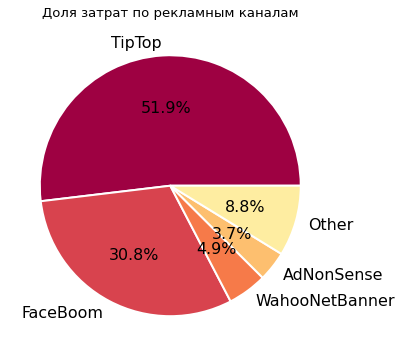

In [19]:
plt.rcParams['font.size'] = 11 #установим размер шрифта
channels = costs.pivot_table(index='channel', 
                               values='costs', 
                               aggfunc='sum').nlargest(4, 'costs').reset_index() 
#построим сводную таблицу и выделим 4 самых крупных каналов
channels = (
    channels.append(
        {'channel': 'Other', 'costs': costs['costs'].sum() - channels['costs'].sum()}, 
        ignore_index= True))
#добавим остальные значения к таблице, сгруппированные в 'Other'
ch_list = costs['channel'].unique().tolist() #превратим в список значения столбца 'channel'
channels.plot(kind='pie',
        y='costs',
        autopct='%1.1f%%',
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large', 'color': 'black'},
        labels= channels.channel,
        figsize=(6, 6),
        legend=False,
        colors = [plt.cm.Spectral(i/float(len(ch_list)-1)) for i in range(len(ch_list))],  
        title = f'Доля затрат по рекламным каналам').set(ylabel='');
#строим круговую диаграмму
display(channels)
#выведем полученную таблицу на экран

**Вывод:** Больше половины затрат на маркетинг пришлись на компанию TipTop (52%), остаток между собой разделили компания FaceBoom (31%), WahooNetBanner (5%), AdNonSense (4%). Компании, доля затрат на которые составила меньше 4% попали в список Other, и их суммарная доля составила около 9%.

Теперь построим график с визуализацией динамики изменения расходов во времени по неделям и месяцам по каждому источнику:

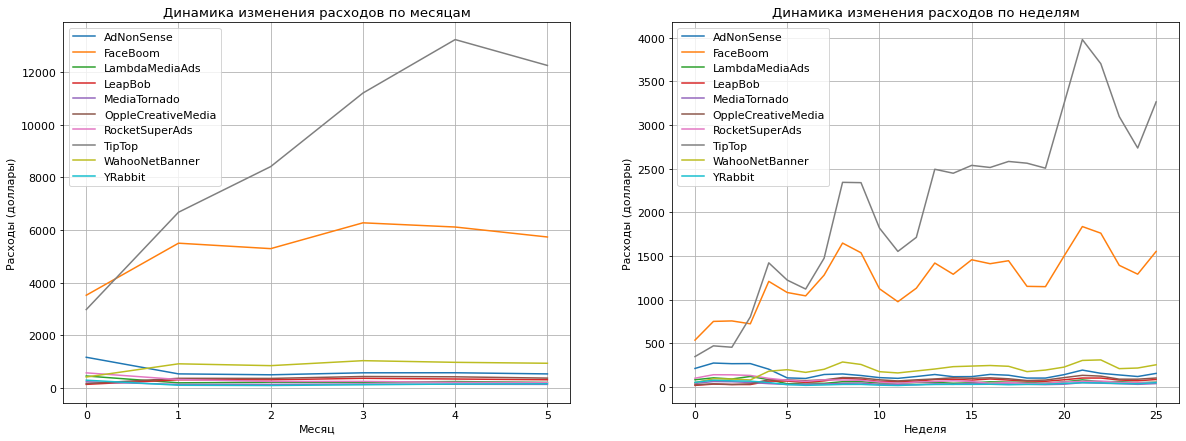

In [20]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].dt.month #добавим к данным значения месяца
costs['week'] = costs['dt'].dt.isocalendar().week #и недели
month = (costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
              .reset_index()
              .drop(columns=['month']))
#сгруппируем помеясячно
week = (costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
            .reset_index()
            .drop(columns=['week']))
#и понедельно
plt.figure(figsize=(20,7)) #задаем размер фигуры
ax1 = plt.subplot(1, 2, 1) #задаем расположение графика
month.plot(grid=True, ax=ax1) #строим график
plt.legend()
plt.xlabel('Месяц')
plt.ylabel ('Расходы (доллары)')
plt.title('Динамика изменения расходов по месяцам') #и оформляем его

ax2 = plt.subplot(1, 2, 2) #задаем расположение второго графика
week.plot(grid=True, ax=ax2) #строим график
plt.legend()
plt.xlabel('Неделя')
plt.ylabel ('Расходы (доллары)')
plt.title('Динамика изменения расходов по неделям'); #и оформляем его

Для наглядности можем убрать самые дорогостоящие каналы, чтобы лучше было видно динамику остальных.

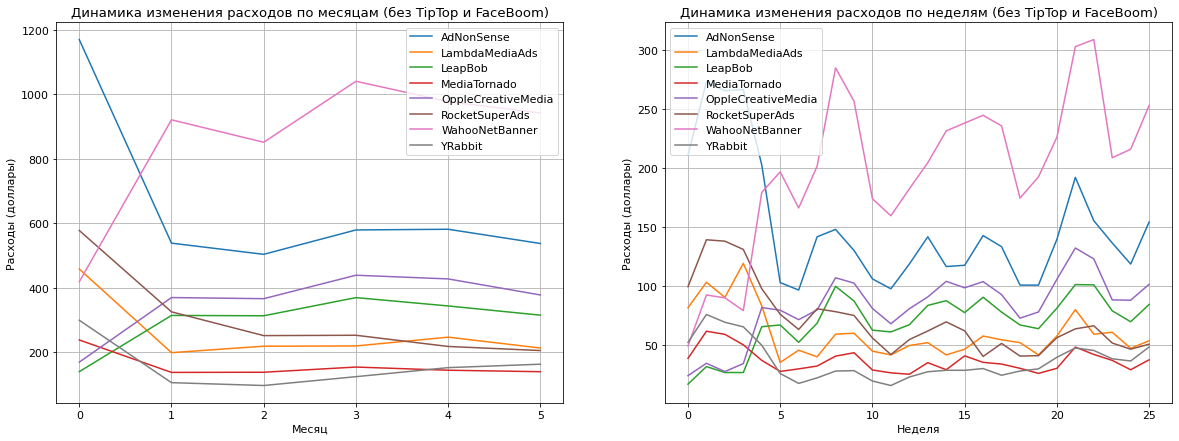

In [21]:
month = month.drop(columns=['TipTop', 'FaceBoom']) #удаляем столбцы со значениями дорогостоящих каналов в месяцах
week = week.drop(columns=['TipTop', 'FaceBoom']) #удаляем столбцы со значениями дорогостоящих каналов в неделях

plt.figure(figsize=(20,7)) #задаем размер фигуры
ax1 = plt.subplot(1, 2, 1) #задаем расположение графика
month.plot(grid=True, ax=ax1) #строим график
plt.legend()
plt.xlabel('Месяц')
plt.ylabel ('Расходы (доллары)')
plt.title('Динамика изменения расходов по месяцам (без TipTop и FaceBoom)') #и оформляем его

ax2 = plt.subplot(1, 2, 2) #задаем расположение второго графика
week.plot(grid=True, ax=ax2) #строим график
plt.legend()
plt.xlabel('Неделя')
plt.ylabel ('Расходы (доллары)')
plt.title('Динамика изменения расходов по неделям (без TipTop и FaceBoom)'); #и оформляем его

**Вывод:** Самые большие затраты на рекламу пришлись на 4 месяц или примерно 21 неделю и составили более 12 000 долларов для компании TipTop. Вилка затрат на услуги компании FaceBoom все месяца держалась в районе 3 000 - 6 000 долларов в месяц или 500-2 000 долларов в неделю. Что касаемо более мелких компаний, в среднем затраты составляли менее 1 000 долларов месяц или 250 долларов в неделю.
В целом, к концу 25 недели расходы начали снова начали возрастать, хотя в отношении к концу 5 месяца расходы только уменьшились.

Теперь выясним, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника, предварительно исключив огранических пользователей, т.к. те пришли без оплаты:

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,LambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


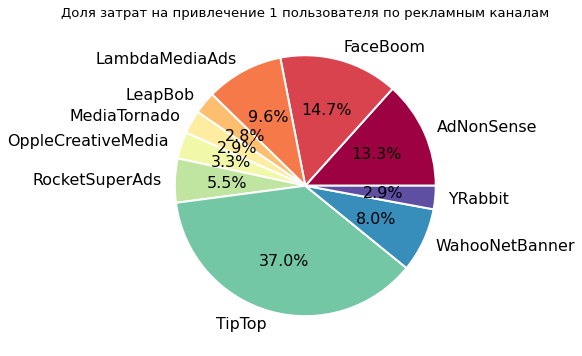

In [22]:
avg_cac = profiles.pivot_table(index='channel', 
                               values='acquisition_cost', 
                               aggfunc='mean').reset_index().query('channel != "Organic"')
#построим сводную таблицу без органических пользователей
avg_cac.plot(kind='pie',
        y='acquisition_cost',
        autopct='%1.1f%%',
        labels= avg_cac.channel,
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large', 'color': 'black'},
        figsize=(6, 6),
        legend=False,
        colors = [plt.cm.Spectral(i/float(len(ch_list)-1)) for i in range(len(ch_list))],  
        title = 'Доля затрат на привлечение 1 пользователя по рекламным каналам').set(ylabel='');
#круговую диаграмму
avg_cac.sort_values(by='acquisition_cost', ascending=False).reset_index(drop=True)
#и выведем таблицу в порядке убывания значений

**Вывод:** При подсчёте среднего CAC для каждой из платформ можно обратить внимание, что максимальная стоимость привлечения одного человека составляет 2,8 долларов для платформы Tip-Top, что превышает в 2,5 раза значения FaceBoom, находящегося на втором месте, хотя средний CAC для данной платформы составляет 1,1 доллар. На третьем месте по доле и затратам находится компания AdNonSense. Разрыв от второго места небольшой, разница в доле составляет 0,6%, а в абсолютных показателях на 0,1 доллара. Остальныее платформы в доле не превышают 10%, а средняя стоимость привлеченного пользователя составляет 0,7 доллара.

## Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 
На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, поэтому зададим соответствующие параметры и уберем из анализа органических пользователей:

In [23]:
observation_date = datetime(2019, 11, 1).date()  #зададим момент анализа
horizon_days = 14  #и горизонт анализа 
profiles = profiles.query('channel != "Organic"') #делаем срез

Теперь можем проанализировать окупаемость рекламы c помощью графиков LTV и ROI, а также построим графики динамики LTV, CAC и ROI.

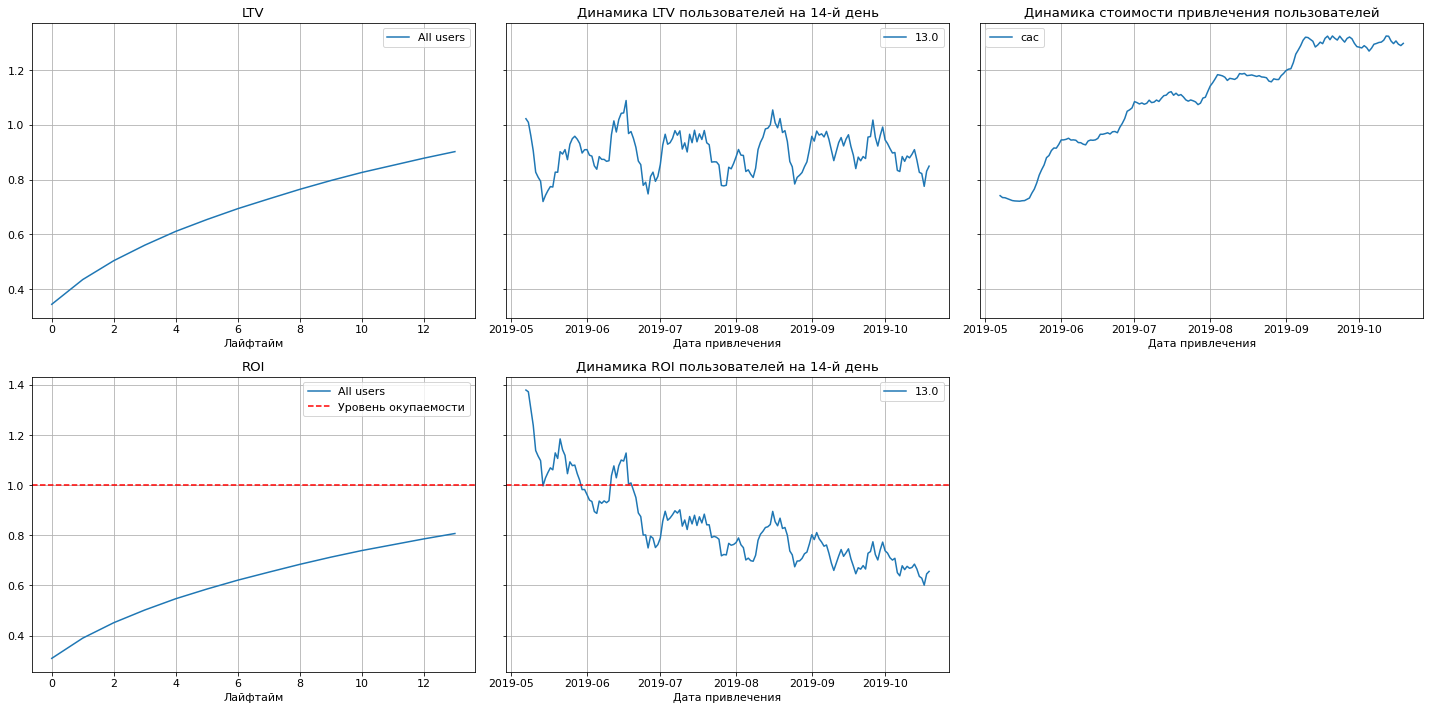

In [24]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)
#считаем LTV и ROI
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 
#строим графики

**Вывод:** На основе данных графиков можно сделать вывод, что реклама не окупается, т.к. ROI в конце недели не пересекает линию, означающую уровень окупаемости, а CAC нестабилен. Возможно дело в увеличении рекламного бюджета, потому что показатель LTV достаточно стабилен, а значит, дело не в ухудшении качества пользователей.

Т.к. это не дает понимания точных причин появления убытков, рассмотрим конверсию и удержание пользователей, а так же динамику их изменения:

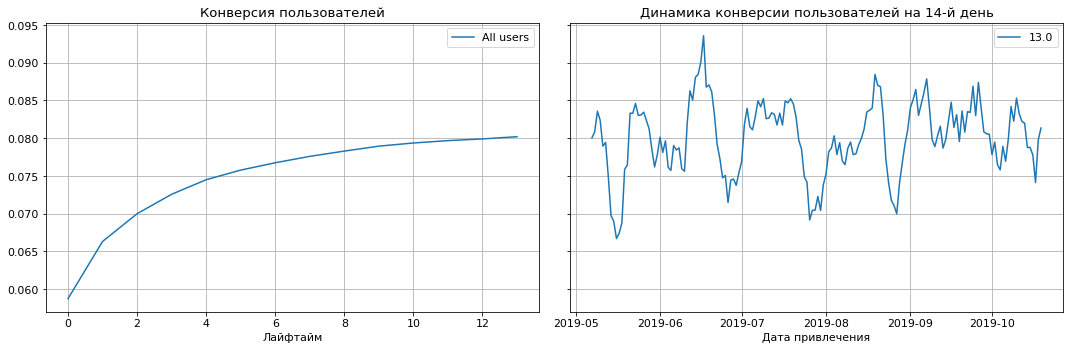

In [25]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)
#считаем удержание
plot_conversion(conversion_grouped, conversion_history, horizon_days)
#строим графики

Судя по графикам, пользователи конвертируются очень хорошо, причём постоянно. Посмотрим, что же тогда с удержанием:

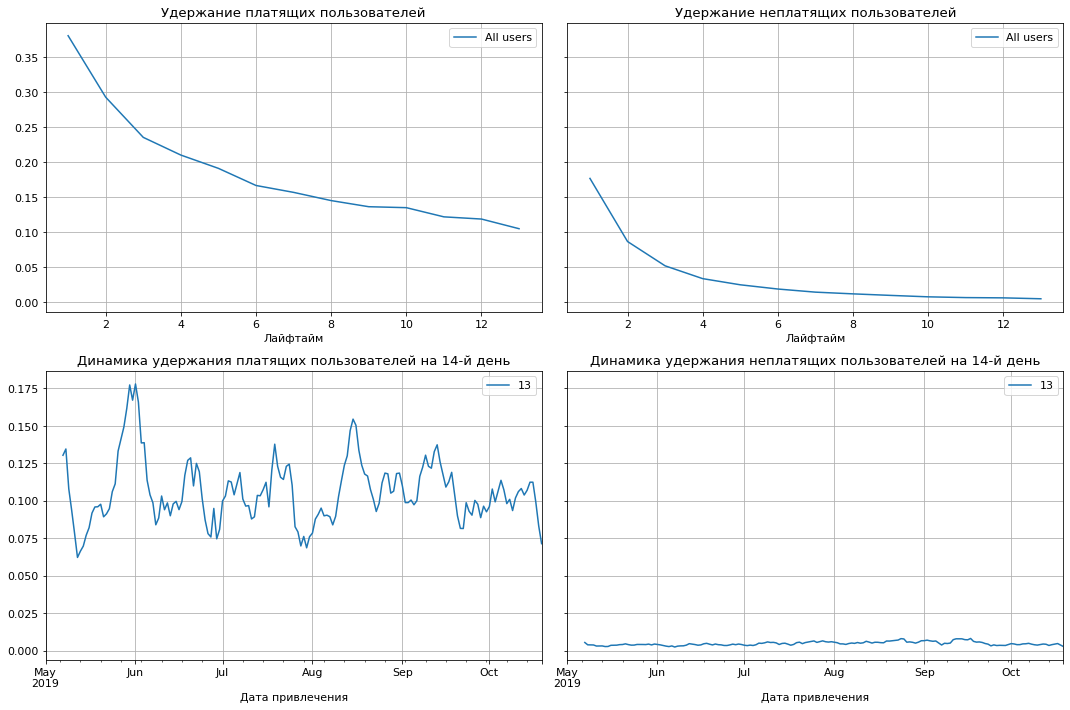

In [26]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)
#считаем удержание
plot_retention(retention_grouped, retention_history, horizon_days)
#строим графики

Удержание стабильно падает, как и для платящих пользователей, так и для неплатящих пользоватей, и несмотря на то, что динамика удержания последних не менялась, их удержание стремится практически к 0.
Возможно существует какая-то проблема и чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — устройству первого посещения, стране и рекламному каналу.

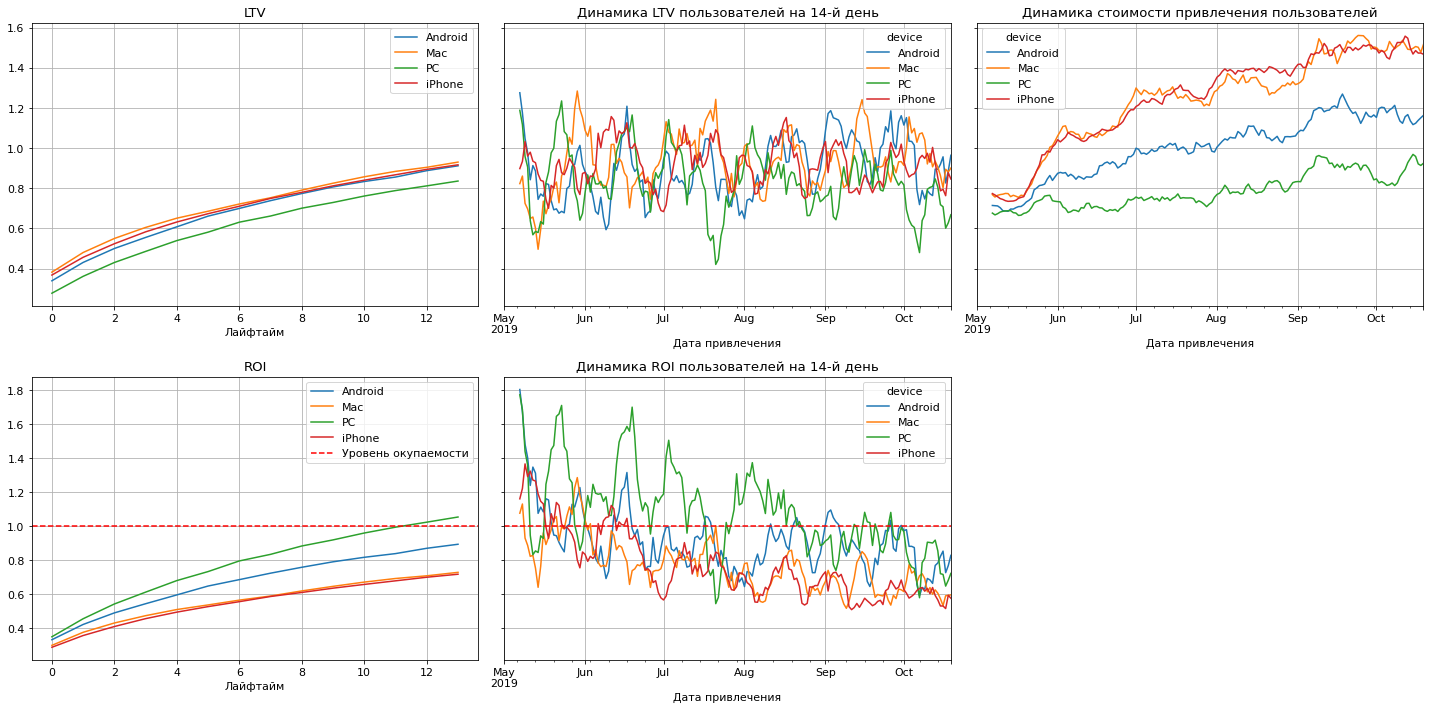

In [27]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['device'])
#считаем LTV и ROI по устройствам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
#строим графики

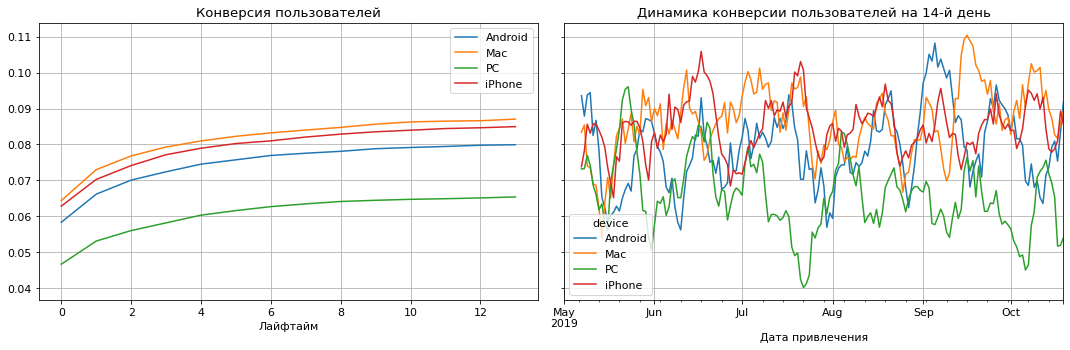

In [28]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, ['device'])
#считаем конверсию в разрезе устройств
plot_conversion(conversion_grouped, conversion_history, horizon_days)
#строим графики

Пользователи PC окупаются, а вот владельцы iPhone и Mac — нет, несмотря на то, что на них тратятся самые большие суммы на привлечение. На это стоить обратить внимание, т.к. оба этих усторойства от одного производителя и имеют схожие операционные системы.
LTV пользователей PC ниже других, но при этом у них самая высокая окупаемость. Вероятно, это из-за самой низкой стоимости привлечения пользователей.
Пользователи на устройствах с операционной системой Andriod были близки к окупаемости, но так и не пересекли черту к 14 дню.
При этом конверсия для всех устройств стабильна, так что возможно проблема в удержании:

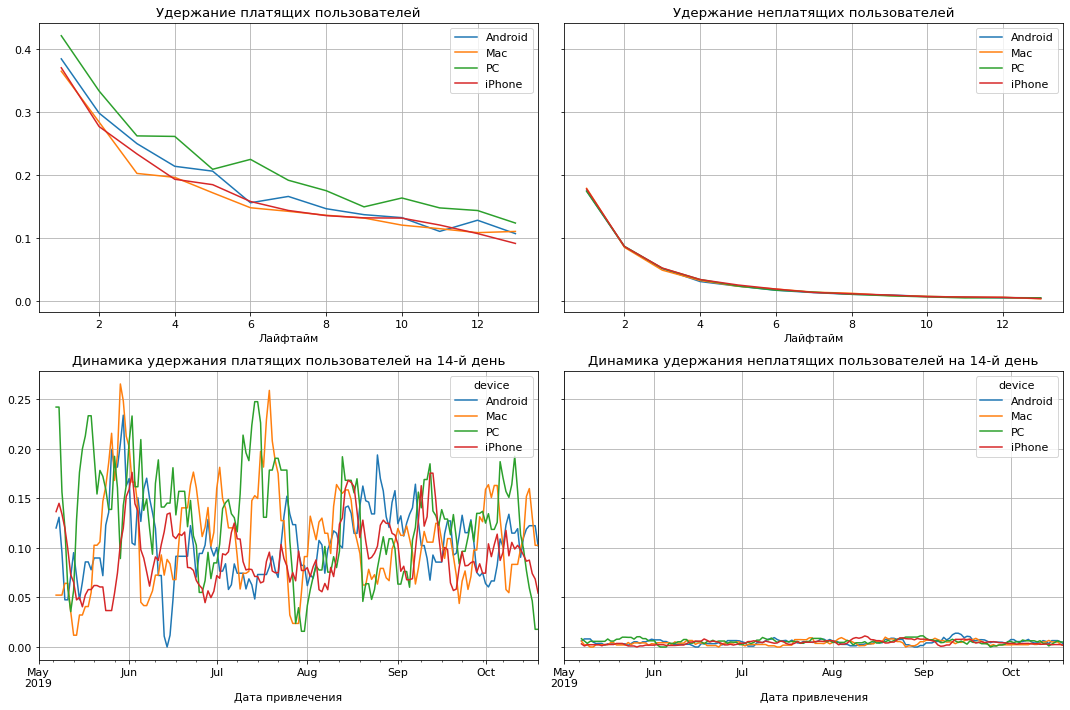

In [29]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['device'])
#считаем удержание по устройствам 
plot_retention(retention_grouped, retention_history, horizon_days) 
#строим графики

Увы, но и с удержанием пользователей всё тоже стабильно плохо. Значит, дело не в устройстве — эту версию можно исключать.

**Вывод:** Пользователи PC окупаются, а вот владельцы iPhone и Mac — нет, несмотря на то, что на них тратятся самые большие суммы на привлечение.
LTV пользователей PC ниже других, но при этом у них самая высокая окупаемость. Вероятно, это из-за самой низкой стоимости привлечения пользователей.
Пользователи на устройствах с операционной системой Andriod были близки к окупаемости, но так и не пересекли черту к 14 дню.
При этом конверсия для всех устройств стабильна, а удержание одинаково страдает для всех устройств, значит дело не в них.

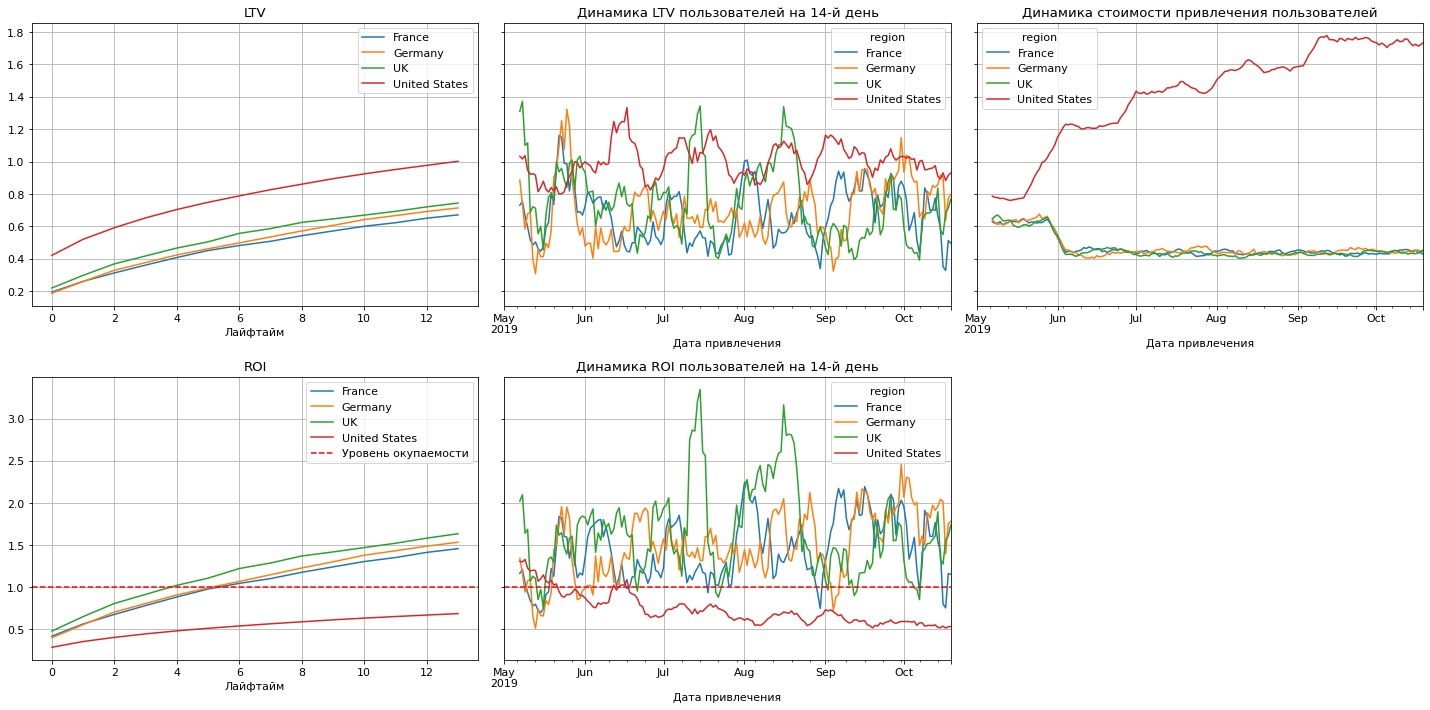

In [30]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['region'])
#считаем LTV и ROI по странам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
#строим графики

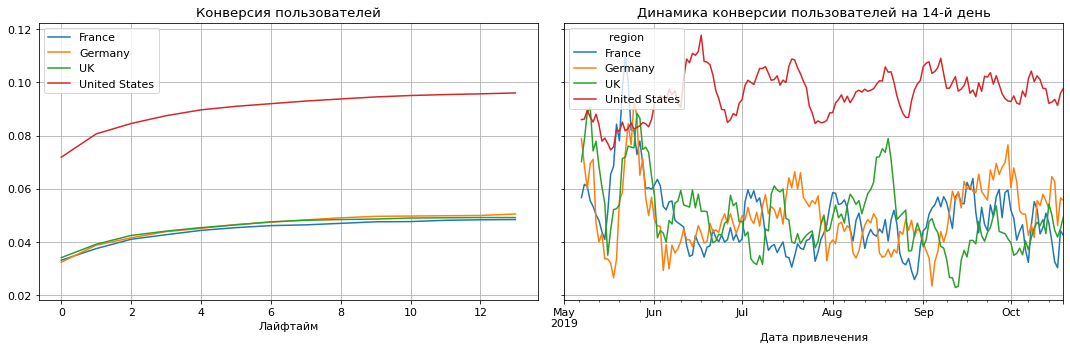

In [31]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, ['region'])
#считаем конверсию в разрезе стран
plot_conversion(conversion_grouped, conversion_history, horizon_days)
#строим графики

Реклама не окупается только в США, несмотря на то, что стоимость привлечения сильно превышает значение стоимости других стран, и имеет самый большой показатель LTV. График динамики стоимости по США выглядит так же как и график по устройствам, вероятно это потому, что ими чаще пользуются именно в США.
При этом конверсия в США сильно превышает конверсию Франции, Германии и Великобритании, это может быть связано с разницей в размерах стран и их жителями, так что проверим удержание:

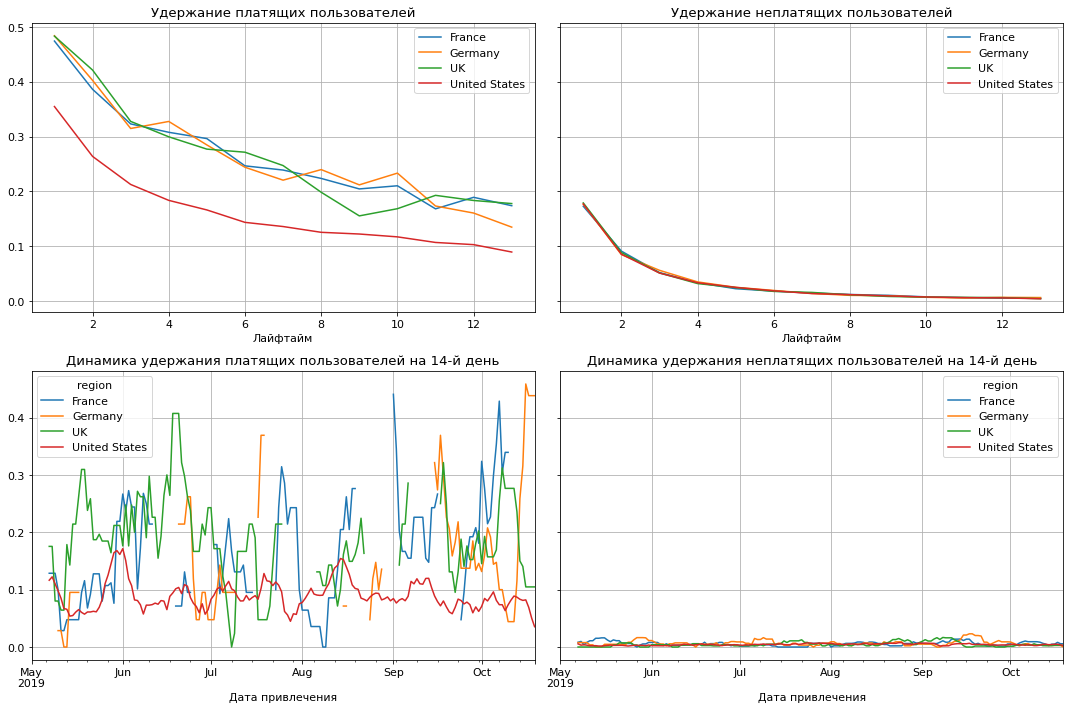

In [32]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['region'])
#считаем удержание по странам
plot_retention(retention_grouped, retention_history, horizon_days) 
#строим графики

Удержание пользователей по странам так же стабильно плохо, и несмотря на то, что пользователи из США удерживаются примерно в два раза хуже, чем пользователи из других стран, нельзя сделать однозначный вывод, что проблема именно в регионе. Так же можем заметить, что только в США стабильно по итогам двух недель происходит удержание платящих пользователей.

**Вывод**: Реклама не окупается только в США, несмотря на то, что стоимость привлечения сильно превышает значение стоимости других стран, и имеет самый большой показатель LTV. График динамики стоимости по США выглядит так же как и график по устройствам, вероятно это потому, что ими чаще пользуются именно в США.
При этом конверсия в США сильно превышает конверсию Франции, Германии и Великобритании, это может быть связано с разницей в размерах стран и их жителями, а удержание пользователей по странам так же стабильно плохо, и несмотря на то, что пользователи из США удерживаются примерно в два раза хуже, чем пользователи из других стран, нельзя сделать однозначный вывод, что проблема именно в регионе. Так же можем заметить, что только в США стабильно по итогам двух недель происходит удержание платящих пользователей.

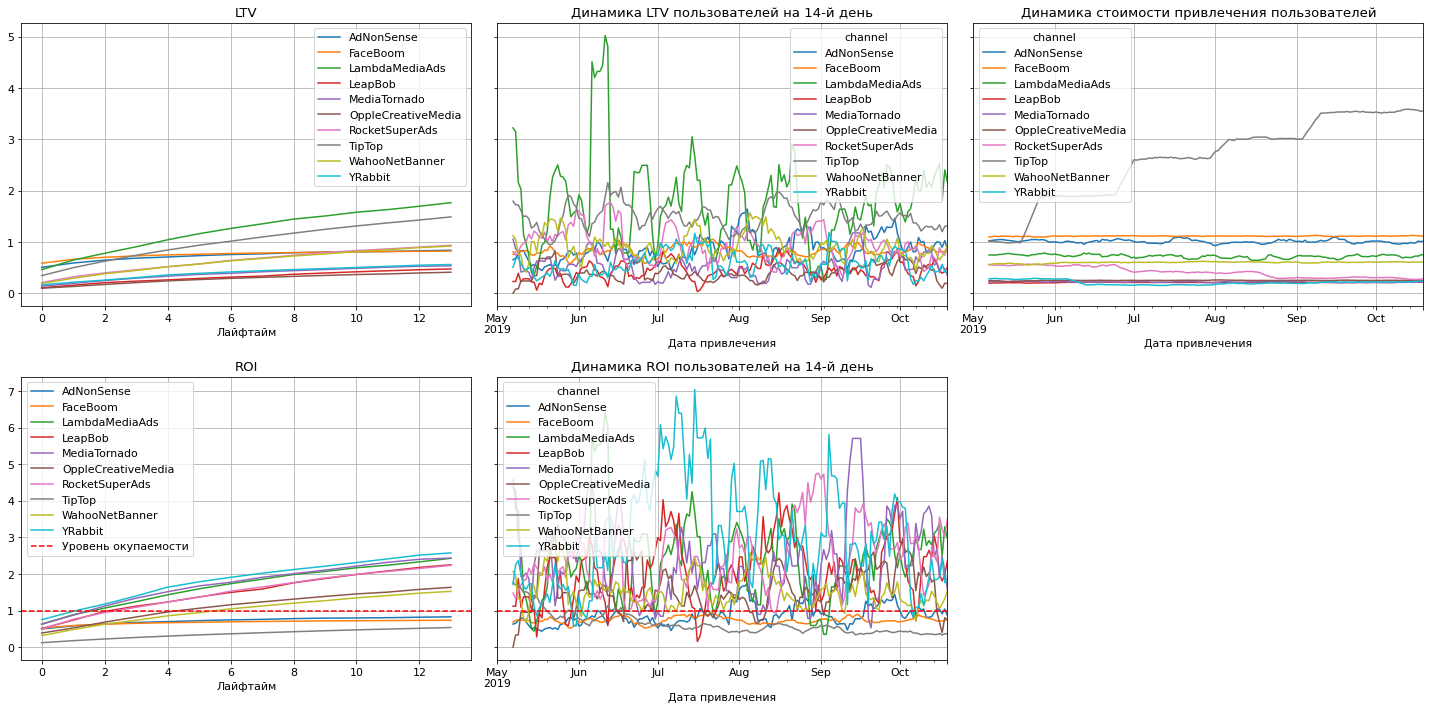

In [33]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, ['channel'])
#считаем LTV и ROI по рекламным каналам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
#строим графики

Линий на графике слишком много, можем разделить рекламные каналы с учетом региона. Для этого возьмем Великобританию, Германию, Францию как группу и отдельно США, т.к. там самые выбивающиеся значения, а затем снова разбить по каналам:

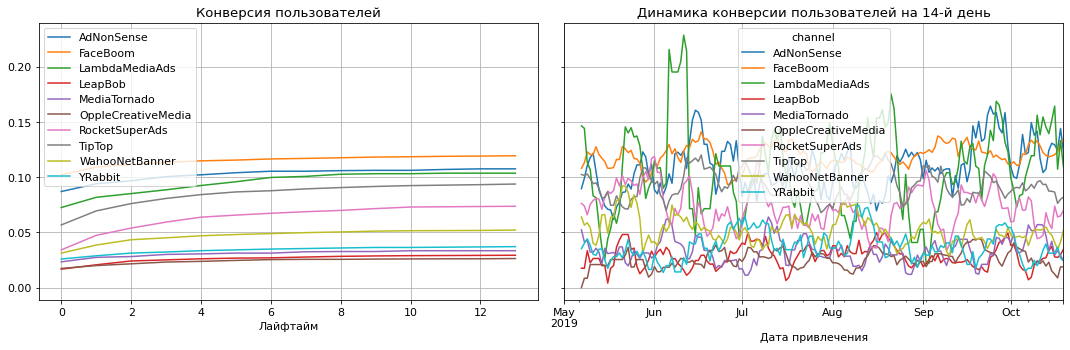

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, ['channel'])
#считаем конверсию в разрезе стран
plot_conversion(conversion_grouped, conversion_history, horizon_days)
#строим графики

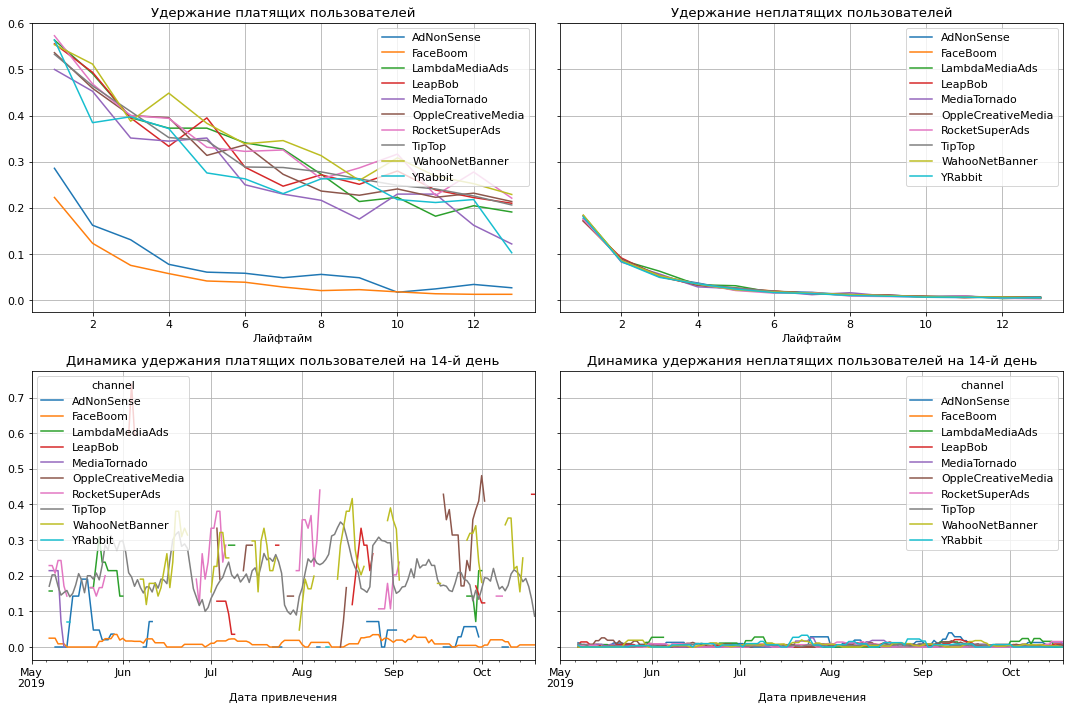

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, ['channel'])
#считаем удержание по устройствам 
plot_retention(retention_grouped, retention_history, horizon_days) 
#строим графики

In [34]:
profiles_usa = profiles.query('region == "United States"')
profiles_west_europe = profiles.query('region != "United States"')
#делаем срез

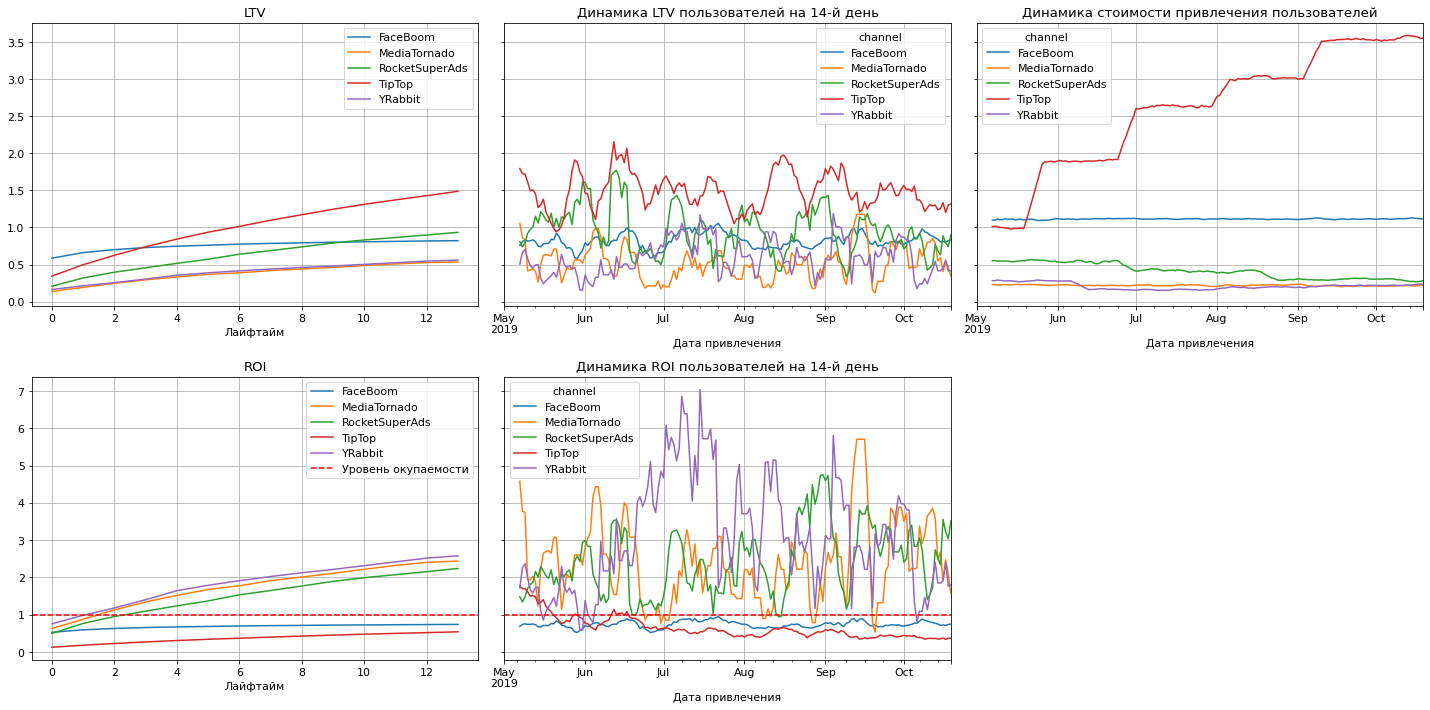

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, ['channel'])
#считаем LTV и ROI по рекламным каналам в США
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
#строим графики

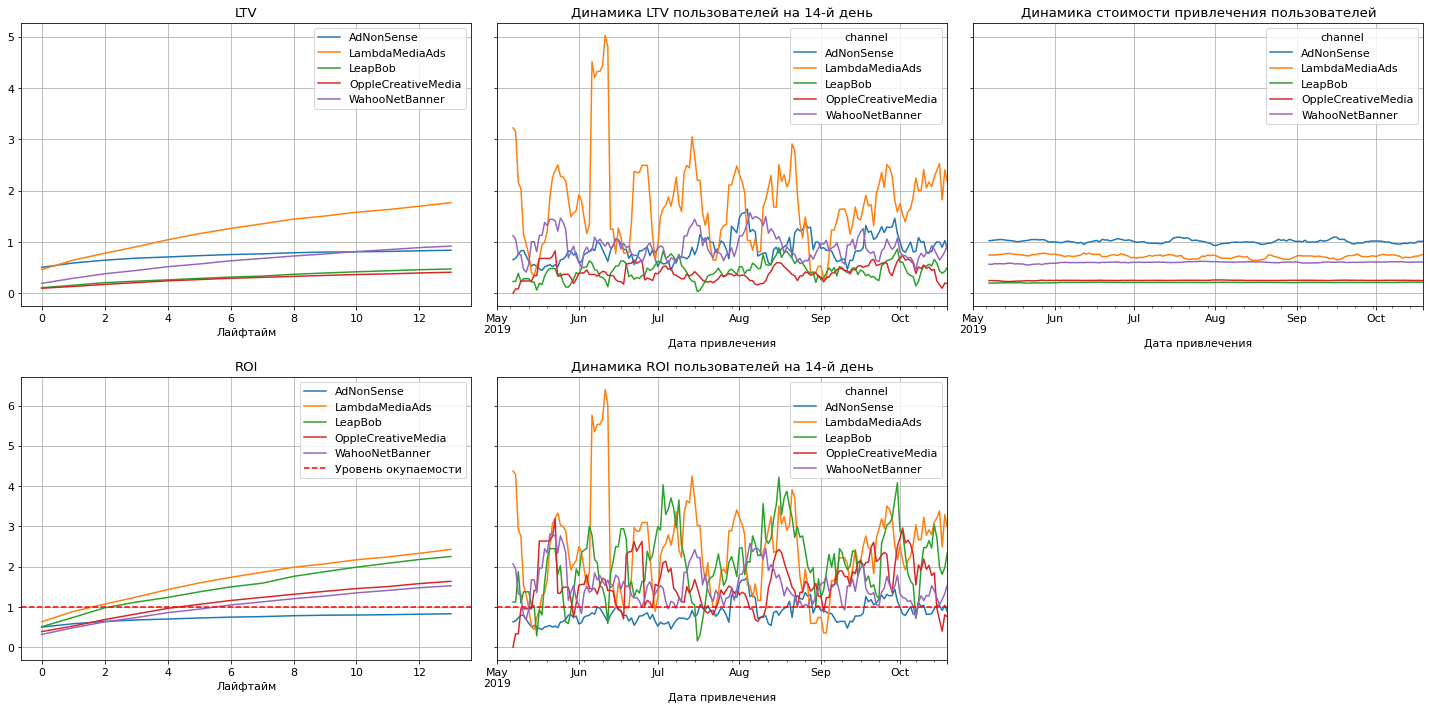

In [36]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_west_europe, orders, observation_date, horizon_days, ['channel'])
#считаем LTV и ROI по рекламным каналам в странах Западной Европы
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
#строим графики

Источники разделились примерно напополам, и теперь мы можем сделать выводы:
Самые дорогостоящие каналы в США (FaceBoom и TipTop) и в странах Западной Европы (AdNonSense) не окупаются, несмотря на то, что LTV для этих компаний достаточно высок. 
При этом затраты именно на компанию TipTop имеют сильно превыщающие значения по сравнению с другими каналами, и самую низкую окупаемость. Можем рассмотреть конверсию и удержание только для вышеуказанных компаний:

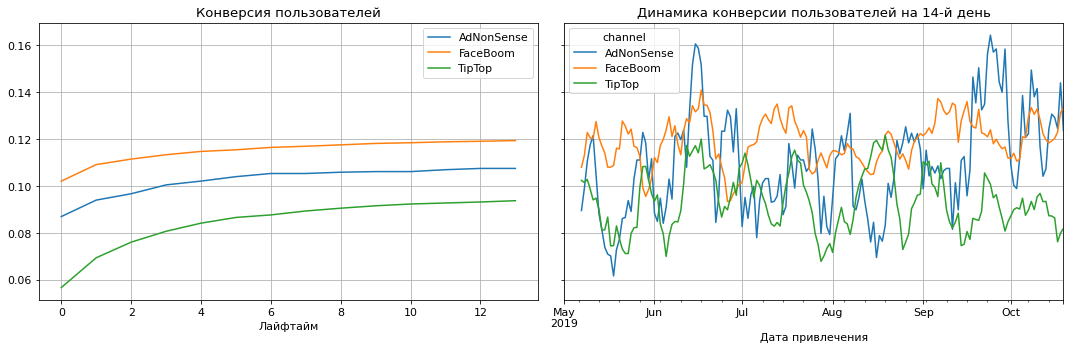

In [37]:
top_3 = ['FaceBoom','TipTop','AdNonSense']
profiles_top = profiles.query('channel == @top_3')
#снова делаем срез

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_top, orders, observation_date, horizon_days, ['channel'])
#считаем конверсию в разрезе 3-х рекламных каналов
plot_conversion(conversion_grouped, conversion_history, horizon_days)
#строим графики

Лучше всего конверсия среди данных каналов держится у FaceBoom, хотя имеет почти одинаковую стоимость привлечения с ADNonSense, которые имеют одни из самых больших затртат, а на первом месте с конца оказался самый дорогостоящий проект TipTop. Посмотрим на удержание:

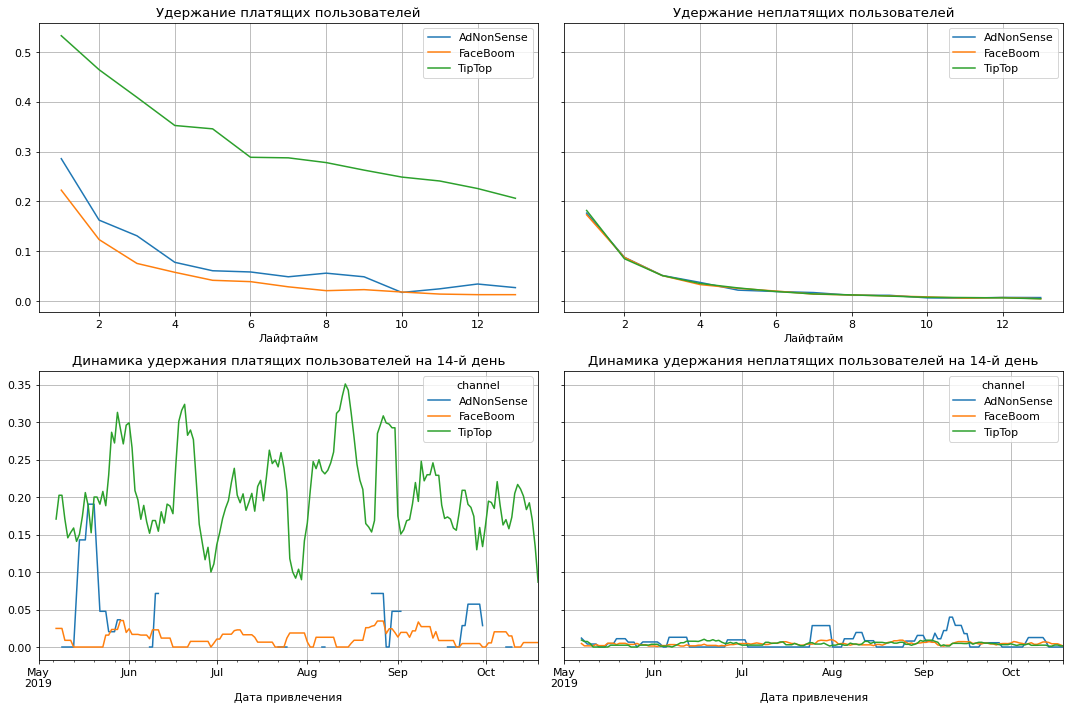

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_top, visits, observation_date, horizon_days, ['channel'])
#считаем удержание в разрезе 3-х рекламных каналов
plot_retention(retention_grouped, retention_history, horizon_days) 
#строим графики

Несмотря на то, что затраты на привлечение через канал TipTop увеличивается, удержание только падает, как и для платящих, так и для неплатящих пользователей.
Динамика AdNonSense вообще имеет прерывистый график, что может говорить об отсутствии постоянства удержания именно платящих пользователей, в то время как для неплатящих эта динамика стабильна и часто имеет большие показатели.
А динамика удержания FaceBoom постоянно стремится к нулю.

**Вывод**: В целом, реклама, направленная на привлечение пользователей, не окупается, а значит данная стратегия показала себя как неэффективная. Негативное влияние на эффективность привлечения пользователей может оказывать использование устройства от компании Apple, пользователи из США, а так же три рекламных канала - TipTop, FaceBoom и AdNonSense, затраты на которые сильно превышают затраты на остальные каналы.

**Рекомендации для отдела маркетинга**:
1. Исключить сотрудничество с каналом AdNonSense для западно-европейского региона, т.к. данная корогта небольшая, хоть и приносит достаточно большую долю платящих пользователей, совершенно не оправдывает вложенные в нее деньги. В данном регионе все остальные компании приносят небольшие, но стабильные результаты, которые окупаются.


2. Снизить затраты, или переподписать условия договора с компанией TipTop. Их основная аудитория как раз из США и возможно поэтому результат увеличения затрат на рекламную программу сказывается на показателях устройств (их предположительно чаще используют в США). Данная компания приносит стабильное количество платящих пользователей, однако увеличение затрат не влияет на пропорциональное увеличение пользователей, и если вернутся к изначальному уровню оплаты - затраты на данный канал будут окупаться.


3. Что касаемо площадки FaceBoom, которая так же негативно оказывает влияние на американский рынок, то с ней нужно обсудить проблемы удержания аудитории, ведь по остальным параметрам это переспективная платформа с большой долей привлечения пользователей в целом.


4. Для западно-европейского региона будет лучше наладить более активное сотрудничество с LambdaMediaAds. Данный рекламный канал имеет высокие параметры LTV, окупаемости и доли платящих пользователей (10,5%), что соответсвует таким гигантам на рынке США как TipTop и FaceBoom, но имеет гораздо более приятную цену за привлечение пользователей. В то время как для американского региона стоит обратить внимание на компанию RocketSuperAds. Несмотря на то, что лидером по окупамости в данном регионе является YRabbit, она не принесет большой доли платящих пользователей и имеет средний LTV.
LTV RocketSuperAds превышает к концу периода FaceBoom, окупаемость средняя по сравнению с остальными (из-за очень дешевых, но не приносящих пользователей компаний) и достаточно большая доля платящих пользователей (8%).

## Общие выводы

**Изначальная цель проекта - разобраться в причинах убытков компании-разработчика приложения Procrastinate Pro+ в последние несколько месяцев и помочь компании выйти в плюс.**

Для этого была проведена предобработка данных, в ходе которой названия столбцов датафрема были приведены в "змеиный" регистр, столбцы, содержащие дату, были приведены в соответствующий тип данных, была осуществлена проверка на дубликаты и пустые значения, значение столбца `channel` приведены к общему виду (названия каналов начинаются с большой буквы).

Далее для дальнейшего исследовательского анализа данных были заданы функция создания профилей пользователей, а так же функции для подсчёта Retention Rate, конверсии LTV и ROI.

С помощью функции `get_profiles` была создана общая таблица, содержащая в себе идентификатор пользователя, дата его первого посещения, канал перехода, тип устройства и страна пользователя, а так же дата без времени, месяц первого посещения, и в конце добавился признак оплаты пользователем и доля рекламных расходов на число привлечённых пользователей.
Согласно данным, пользователи привлекались с 1 мая 2019 года по 27 октября 2019 года.

Далее было определено из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи, а так же рекламные источники привлечения и каналы, из которых пришло больше всего платящих пользователей.
Самой многочисленной когортой в разрезе стран оказалась США и у нее же самая большая доля платящих пользователей (6,9%). Что касаемо устройств - в лидерах по количеству пользователей оказался iPhone, хотя доля платных пользователей приложения (6,2%) уступает самой малочисленной когорте - пользователям Mac (6,4%). 
В рекламных источниках привлечения можно выделить три самые большие когорты - это Organic, FaceBoom и TipTop.
Несмотря на размер, платные пользователи, пришедшие органическим путем имеют самую маленькую долю (2,1%), FaceBoom со вторым местом по количеству наоборот занимает первое место по доле платных пользователей (12,2%), на третьем месте по доле находится канал AdNonSense (11,3%), у которого одна из самых малочисленных когорт.

Общая сумма расходов на маркетинг составляет 105497.3 долларов, из которых больше половины пришлись на компанию TipTop (52%), остаток между собой разделили компания FaceBoom (31%), WahooNetBanner (5%), AdNonSense (4%). Компании, доля затрат на которые составила меньше 4% попали в список Other, и их суммарная доля составила около 9%.

Самые большие затраты на рекламу пришлись на 4 месяц или примерно 21 неделю и составили более 12 000 долларов для компании TipTop. Вилка затрат на услуги компании FaceBoom все месяца держалась в районе 3 000 - 6 000 долларов в месяц или 500-2 000 долларов в неделю. Что касаемо более мелких компаний, в среднем затраты составляли менее 1 000 долларов месяц или 250 долларов в неделю.
В целом, к концу 25 недели расходы начали снова начали возрастать, хотя в отношении к концу 5 месяца расходы только уменьшились.

При подсчёте среднего CAC для каждой из платформ можно обратить внимание, что максимальная стоимость привлечения одного человека составляет 2,8 долларов для платформы Tip-Top, что превышает в 2,5 раза значения FaceBoom, находящегося на втором месте, хотя средний CAC для данной платформы составляет 1,1 доллар. На третьем месте по доле и затратам находится компания AdNonSense. Разрыв от второго места небольшой, разница в доле составляет 0,6%, а в абсолютных показателях на 0,1 доллара. Остальныее платформы в доле не превышают 10%, а средняя стоимость привлеченного пользователя составляет 0,7 доллара.


**Рассмотрим причины неэффективности привлечения пользователей:**

Реклама не окупается, т.к. ROI в конце недели не пересекает линию, означающую уровень окупаемости, а CAC нестабилен. Возможно дело в увеличении рекламного бюджета, потому что показатель LTV достаточно стабилен, а значит, дело не в ухудшении качества пользователей. Удержание стабильно падает, как и для платящих пользователей, так и для неплатящих пользоватей, и несмотря на то, что динамика удержания последних не менялась, их удержание стремится практически к 0.

Пользователи Android и PC окупаются, а вот владельцы iPhone и Mac — нет, несмотря на то, что на них тратятся самые большие суммы на привлечение.
LTV пользователей PC ниже других, но при этом у них самая высокая окупаемость. Вероятно, это из-за самой низкой стоимости привлечения пользователей.
Пользователи на устройствах с операционной системой Andriod были близки к окупаемости, но так и не пересекли черту к 14 дню.
При этом конверсия для всех устройств стабильна, а удержание одинаково страдает для всех устройств, значит дело не в них.

Реклама не окупается только в США, несмотря на то, что стоимость привлечения сильно превышает значение стоимости других стран, и имеет самый большой показатель LTV. График динамики стоимости по США выглядит так же как и график по устройствам, вероятно это потому, что ими чаще пользуются именно в США.
При этом конверсия в США сильно превышает конверсию Франции, Германии и Великобритании, это может быть связано с разницей в размерах стран и их жителями, а удержание пользователей по странам так же стабильно плохо, и несмотря на то, что пользователи из США удерживаются примерно в два раза хуже, чем пользователи из других стран, нельзя сделать однозначный вывод, что проблема именно в регионе. Так же можем заметить, что только в США стабильно по итогам двух недель происходит удержание платящих пользователей.

Самые дорогостоящие каналы в США (FaceBoom и TipTop) и в странах Западной Европы (AdNonSense) не окупаются, несмотря на то, что LTV для этих компаний достаточно высок. 
При этом затраты именно на компанию TipTop имеют сильно превыщающие значения по сравнению с другими каналами, и самую низкую окупаемость.
Лучше всего конверсия среди этих каналов держится у FaceBoom, хотя имеет почти одинаковую стоимость привлечения с ADNonSense, которые имеют одни из самых больших затртат, а на первом месте с конца оказался самый дорогостоящий проект TipTop. 

Несмотря на то, что затраты на привлечение через канал TipTop увеличиваются, удержание только падает, как и для платящих, так и для неплатящих пользователей.
Динамика AdNonSense вообще имеет прерывистый график, что может говорить об отсутствии постоянства удержания именно платящих пользователей, в то время как для неплатящих эта динамика стабильна и часто имеет большие показатели.
А динамика удержания FaceBoom постоянно стремится к нулю.

По итогу, можно сделать вывод, что в целом, реклама, направленная на привлечение пользователей, не окупается, а значит данная стратегия показала себя как неэффективная. Негативное влияние на эффективность привлечения пользователей может оказывать использование устройства от компании Apple, пользователи из США, а так же три рекламных канала - TipTop, FaceBoom и AdNonSense, затраты на которые сильно превышают затраты на остальные каналы.

**В связи с этим можно составить рекомендации для отдела маркетинга**:

1. Исключить сотрудничество с каналом AdNonSense для западно-европейского региона, т.к. данная корогта небольшая, хоть и приносит достаточно большую долю платящих пользователей, совершенно не оправдывает вложенные в нее деньги. В данном регионе все остальные компании приносят небольшие, но стабильные результаты, которые окупаются.


2. Снизить затраты, или переподписать условия договора с компанией TipTop. Их основная аудитория как раз из США и возможно поэтому результат увеличения затрат на рекламную программу сказывается на показателях устройств (их предположительно чаще используют в США). Данная компания приносит стабильное количество платящих пользователей, однако увеличение затрат не влияет на пропорциональное увеличение пользователей, и если вернутся к изначальному уровню оплаты - затраты на данный канал будут окупаться.


3. Что касаемо площадки FaceBoom, которая так же негативно оказывает влияние на американский рынок, то с ней нужно обсудить проблемы удержания аудитории, ведь по остальным параметрам это переспективная платформа с большой долей привлечения пользователей в целом.


4. Для западно-европейского региона будет лучше наладить более активное сотрудничество с LambdaMediaAds. Данный рекламный канал имеет высокие параметры LTV, окупаемости и доли платящих пользователей (10,5%), что соответсвует таким гигантам на рынке США как TipTop и FaceBoom, но имеет гораздо более приятную цену за привлечение пользователей. В то время как для американского региона стоит обратить внимание на компанию RocketSuperAds. Несмотря на то, что лидером по окупамости в данном регионе является YRabbit, она не принесет большой доли платящих пользователей и имеет средний LTV.
LTV RocketSuperAds превышает к концу периода FaceBoom, окупаемость средняя по сравнению с остальными (из-за очень дешевых, но не приносящих пользователей компаний) и достаточно большая доля платящих пользователей (8%).